In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

# import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf


# Cleaning Dataset (todo in P3 main file)

In [20]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

actors_movies_all = actors.droplevel(0, axis=1).merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)
actors_movies_all = actors_movies_all.drop(columns=['birthYear', 'movie_count_genre'])
actors_movies_all = actors_movies_all.replace("\\N", pd.NA)

In [21]:
import networkx as nx
# Create an empty dictionary to store centrality values for each year
centrality_dict = {}

# Create an empty graph
B = nx.Graph()

# Loop over unique years
for year in actors_movies_all['Movie release date'].unique():
    # Filter the DataFrame up to the current year
    current_year_data = actors_movies_all[actors_movies_all['Movie release date'] <= year]

    # Add nodes with the 'bipartite' attribute
    B.add_nodes_from(current_year_data.index.get_level_values('IMDb_actor_ID'), bipartite=0)
    B.add_nodes_from(current_year_data.index.get_level_values('IMDb_ID'), bipartite=1)

    # Add edges between actors and movies
    B.add_edges_from(current_year_data.index)

    # Project the bipartite graph onto the actor nodes
    actor_graph = nx.bipartite.projected_graph(B, nodes=current_year_data.index.get_level_values('IMDb_actor_ID'))

    # Calculate the degree of centrality
    centrality = nx.degree_centrality(actor_graph)

    # Add centrality values to the dictionary for the current year
    centrality_dict[year] = centrality.copy()



In [22]:
centrality_df

,IMDb_actor_ID,Movie release date,actor_connections
0,nm0000449,2001,0.0
1,nm0000449,1995,0.0
2,nm0000449,1998,0.0
3,nm0000449,2000,0.0
4,nm0000449,2009,0.0
...,...,...,...
330149,nm0693799,2012,0.0
330150,nm4921260,2012,0.0
330151,nm1546686,2012,0.0
330152,nm4462184,2012,0.0


In [23]:
# Convert the dictionary of centrality values to a DataFrame
centrality_df = pd.DataFrame.from_dict(centrality_dict, orient='columns').stack().to_frame().reset_index()
centrality_df = centrality_df.rename(columns={"level_0": "IMDb_actor_ID", "level_1": "Movie release date", 0:"actor_connections"})

tmp=actors_movies_all.reset_index()
actors_movies_all = pd.merge(tmp,centrality_df, on=["IMDb_actor_ID","Movie release date"], how = "inner")
actors_movies_all=actors_movies_all.set_index(['IMDb_ID','IMDb_actor_ID'])

In [24]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=10):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)


actors_movies_all = actors_movies_all.sort_values(by='Movie release date')
actors_movies_all['ReleaseYearRange'] = actors_movies_all['Movie release date'].apply(lambda x: create_range(x))

In [25]:
# Calculate the 30th and 70th percentiles
low_threshold = actors_movies_all['averageRating'].quantile(0.05)
high_threshold = actors_movies_all['averageRating'].quantile(0.95)

# Filter the DataFrame to keep only the rows in the lowest 30% and highest 30%
actors_movies = actors_movies_all[(actors_movies_all['averageRating'] <= low_threshold) | (actors_movies_all['averageRating'] >= high_threshold)]
actors_movies['is_good'] = actors_movies['averageRating']> 6
actors_movies['has_award']= actors_movies['awards'] > 0
actors_movies['has_nomination'] = actors_movies['nominations'] > 0 

/var/folders/z9/my0231p10vvfs14g99r4prz40000gn/T/ipykernel_92412/371443532.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_movies['is_good'] = actors_movies['averageRating']> 6
/var/folders/z9/my0231p10vvfs14g99r4prz40000gn/T/ipykernel_92412/371443532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_movies['has_award']= actors_movies['awards'] > 0
/var/folders/z9/my0231p10vvfs14g99r4prz40000gn/T/ipykernel_92412/371443532.py:9: SettingWithCopyWarning: 
A value is trying to be set on a co

In [26]:
display(actors_movies)

ordering  Wikipedia movie ID  \
IMDb_ID   IMDb_actor_ID                                 
tt0021202 nm0824496             1            29472951   
          nm0820607             3            29472951   
tt0020982 nm0393028             1            31211258   
          nm0345073             2            31211258   
          nm0908963             3            31211258   
...                           ...                 ...   
tt2181931 nm0004437             1            34244761   
tt1618467 nm0843401             1            27974525   
          nm3881145             2            27974525   
          nm0917353             3            27974525   
tt2387495 nm5115680             2            35900773   

                                          Movie name  Movie release date  \
IMDb_ID   IMDb_actor_ID                                                    
tt0021202 nm0824496             The Oklahoma Cyclone                1930   
          nm0820607             The Oklahoma Cyclone                1930   
tt0020982 nm0393028                       Hokuspokus                1930   
          nm0345073                       Hokuspokus                1930   
          nm0908963                       Hokuspokus                1930   
...                                              ...                 ...   
tt2181931 nm0004437                 English Vinglish                2012   
tt1618467 nm0843401                       Booked Out                2012   
          nm3881145                       Booked Out                2012   
          nm0917353                       Booked Out                2012   
tt2387495 nm5115680      Jalpari: The Desert Mermaid                2012   

                              primaryName  awards  nominations  movie_count  \
IMDb_ID   IMDb_actor_ID                                                       
tt0021202 nm0824496            Bob Steele       0            0            1   
          nm0820607           Al St. John       0            0            1   
tt0020982 nm0393028         Oscar Homolka       0            0            1   
          nm0345073      Gustaf Gründgens       0            0            1   
          nm0908963         Otto Wallburg       0            0            1   
...                                   ...     ...          ...          ...   
tt2181931 nm0004437               Sridevi       0            0           27   
tt1618467 nm0843401           Sylvia Syms       0            0           17   
          nm3881145         Kathryn Kelly       0            0            1   
          nm0917353           Rollo Weeks       0            0            2   
tt2387495 nm5115680      Krishang Trivedi       0            0            1   

                         genres_b4  isMale  age_at_release  averageRating  \
IMDb_ID   IMDb_actor_ID                                                     
tt0021202 nm0824496              1       1              23            3.8   
          nm0820607              1    <NA>              37            3.8   
tt0020982 nm0393028              4       1              32            7.6   
          nm0345073              1       1              31            7.6   
          nm0908963              1    <NA>              41            7.6   
...                            ...     ...             ...            ...   
tt2181931 nm0004437              1    <NA>              49            7.8   
tt1618467 nm0843401              1       0              78            7.7   
          nm3881145              1    <NA>            <NA>            7.7   
          nm0917353              1       1              25            7.7   
tt2387495 nm5115680              1    <NA>            <NA>            7.9   

                         actor_connections ReleaseYearRange  is_good  \
IMDb_ID   IMDb_actor_ID                                                
tt0021202 nm0824496               0.022472      1930 - 1940    False   
          nm0820607               0.012841      

# First analysis using t-test

In [27]:
# - ttest pour chaque feature sur toutes années confondues (6 ttest) (Armance)
#     - voire influence generale

# Text résumant les résultats

# Visualizing the evolution of features over time

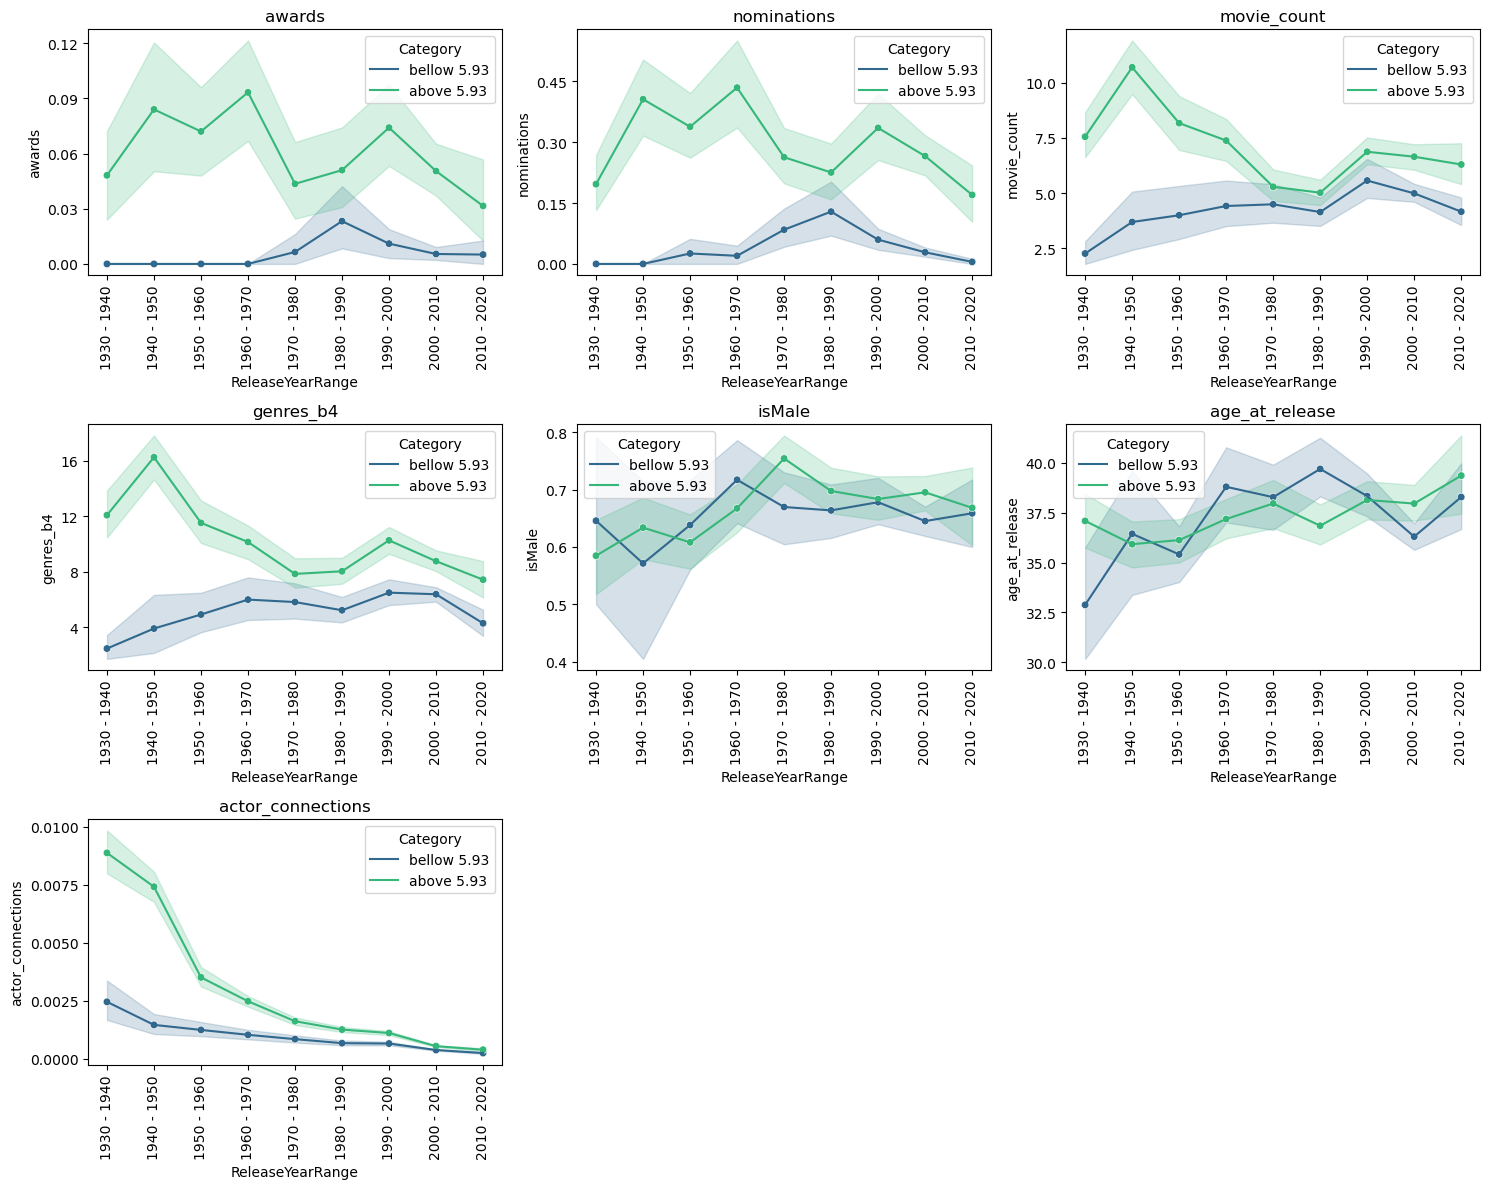

In [28]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    # me = df.copy()
    
    lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
    hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
    # me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        # me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        # me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        # me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        # me_filtered_mean['Category'] = 'mean'

        # frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame = pd.concat([lo_filtered, hi_filtered])

        # frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

mean_rating = round(actors_movies['averageRating'].mean(), 2)
do_fancy_ecpi_cute_plot(actors_movies, 'mean_rating', 'averageRating', 'ReleaseYearRange', 
                        ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release', 'actor_connections'], 
                        ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release', 'actor_connections'])

- Awards: Actors in movies rated above 6.03 tend to have accumulated more awards across the years compared to those in movies with ratings below 6.03.

- Nominations: Similarly, actors in higher-rated movies have received more nominations over the years.

- Movie Count: Actors in higher-rated movies have appeared in a greater number of movies, especially in the time frame from the 1940s to the early 2000s.

- Genres Before Current Movie (genres_b4): Actors in higher-rated movies have tended to play in a greater variety of genres before their current movie, with the difference being most pronounced in the early release years.

- IsMale (Gender Distribution): The proportion of male actors varies with time, and there's a higher proportion of male actors in movies above the 6.03 rating threshold in certain time periods. However, the overlapping confidence intervals suggest a significant variance in the data.

- Age at Release: Actors in higher-rated movies are generally older, particularly noticeable from the 1980s onward, whereas in earlier decades, the trend is not as distinct.

The plots suggest there are observable differences in the features of actors between high and low-rated movies. Specifically, actors in higher-rated movies have a history of more awards and nominations, have appeared in more movies, have had experience across a wider range of genres before the current movie, and are typically older at the time of the movie's release. The gender distribution is somewhat variable and does not show as clear a trend. These findings indicate that actors' experience and recognition (in terms of awards and variety of roles) may correlate with the ratings of the movies they are in.

# Awards X Average Ratings

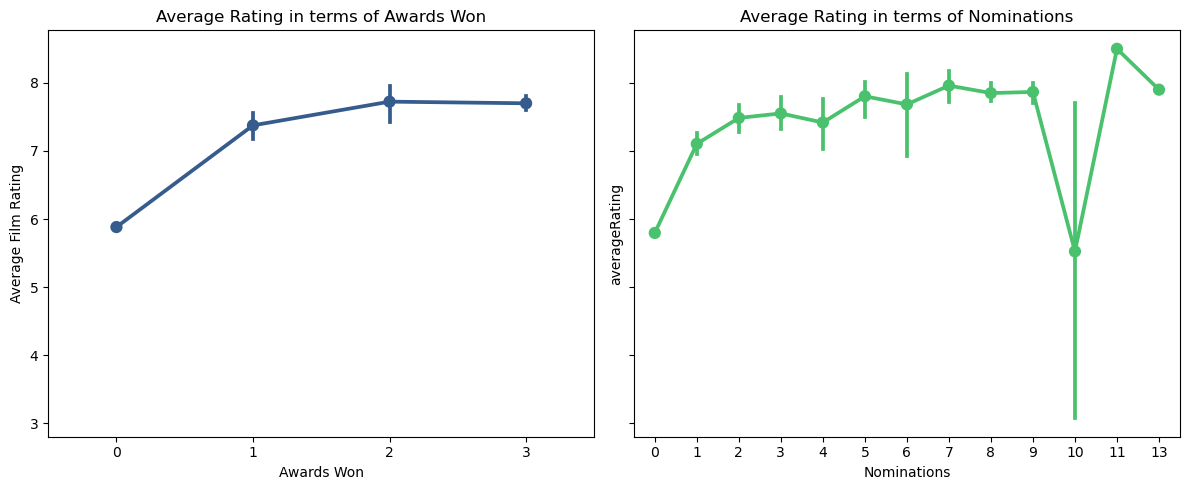

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot 1
plt.subplot(1, 2, 1)
sns.pointplot(x='awards', y='averageRating', data=actors_movies, errorbar=('ci', 95), color=sns.color_palette('viridis')[1])
plt.title("Average Rating in terms of Awards Won")
plt.xlabel("Awards Won")
plt.ylabel("Average Film Rating")

# Plot 2
plt.subplot(1, 2, 2)
sns.pointplot(x='nominations', y='averageRating', data=actors_movies, errorbar=('ci', 95), color=sns.color_palette('viridis')[4])
plt.title("Average Rating in terms of Nominations")
plt.xlabel("Nominations")

plt.tight_layout()
plt.show()

[]

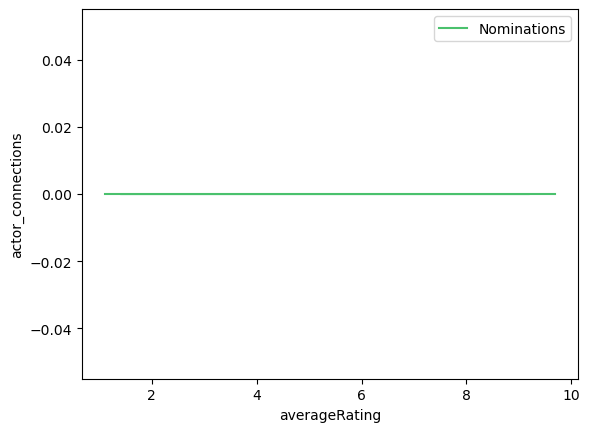

In [11]:
sns.lineplot(x='averageRating', y='actor_connections', data=actors_movies, errorbar=('ci', 95), label='Nominations',color=sns.color_palette('viridis')[4])
plt.plot()

These two plots show that there is indeed a significant difference in movie ratings in terms of oscars won and nominations recieved. In other words, actors with oscars and nominations generelly play in better rated films. 

On the nominations plot, the confidence interval explodes after 6 nominations due to little data, however before that we can see an significant incresing trend before that.

Another interesting observation is that we can we can distinguish films with and without awards, as having more than one award is not statistical significant.


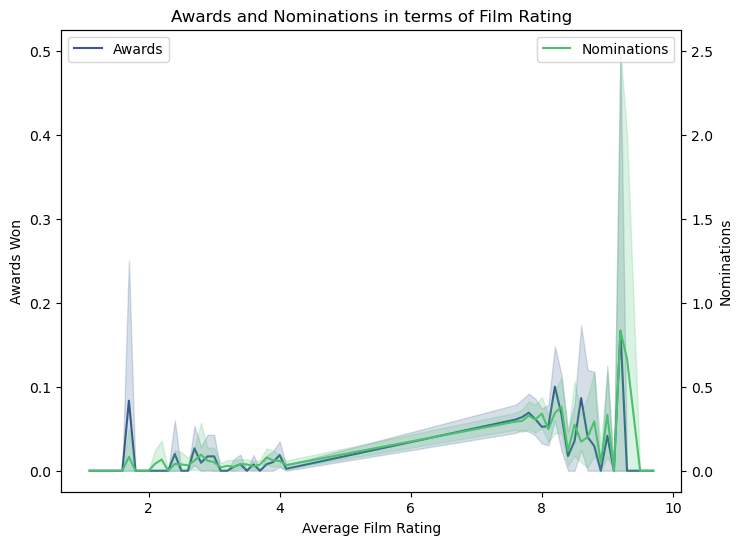

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already calculated and filtered 'actors_movies' DataFrame

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot on the first y-axis
sns.lineplot(x='averageRating', y='awards', data=actors_movies, errorbar=('ci', 95), ax=ax1, label='Awards', color=sns.color_palette('viridis')[1])
ax1.set_xlabel("Average Film Rating")
ax1.set_ylabel("Awards Won")

# Create a second y-axis and plot on it
ax2 = ax1.twinx()
sns.lineplot(x='averageRating', y='nominations', data=actors_movies, errorbar=('ci', 95), ax=ax2, label='Nominations',color=sns.color_palette('viridis')[4])
ax2.set_ylabel("Nominations")

# Display legends for both lines
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout
plt.title("Awards and Nominations in terms of Film Rating")
plt.show()

An other way of looking at this data is plotting the average awards won/nominations per rating, shown in the plot above.As mentionned before, we can see the correlations between these two plots. We can alsoobserve a steady rise in awards won and nominations as the raiting increases meaning that films with high ratings generally have more oscars and nominations. Unfortunalty, we don't have enough data in the higher film ratings, hence the high confidence interval.

# Feature Correlation

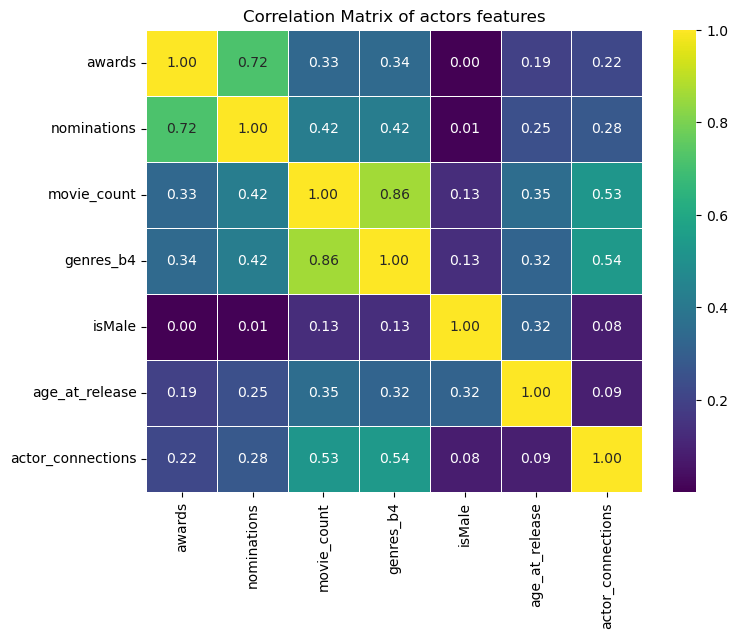

In [34]:
# - Correlation Emeline (Emeline)
#     - Correspond avec graph dimi mais en term de correlation

# Calculate the correlation matrix
correlation_matrix = actors_movies[['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release', 'actor_connections']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix of actors features')
plt.show()

# Correlation Features with Ratings

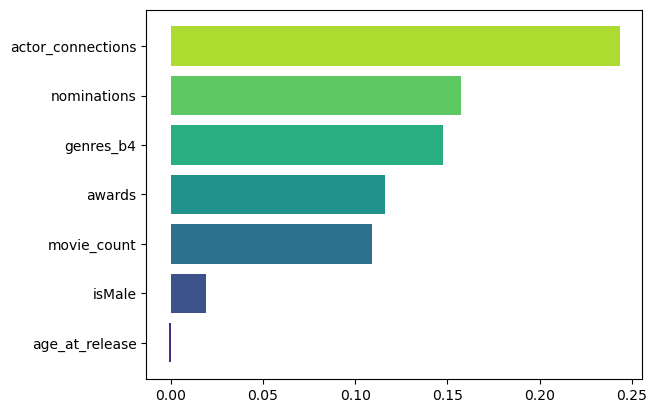

In [31]:
correlation_matrix=actors_movies[[ 'awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release','averageRating', 'actor_connections']].corr()
correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')  # Remove correlation with itself
correlation_with_X_sorted = correlation_with_X.sort_values()
# Create a horizontal bar plot
plt.barh(correlation_with_X_sorted.index, correlation_with_X_sorted, color=sns.color_palette('viridis', n_colors=len(correlation_with_X_sorted)))
plt.show()

Here we can see that nominations, genres_b4 and awards are the 3 features with the highest correlation with the movie rating

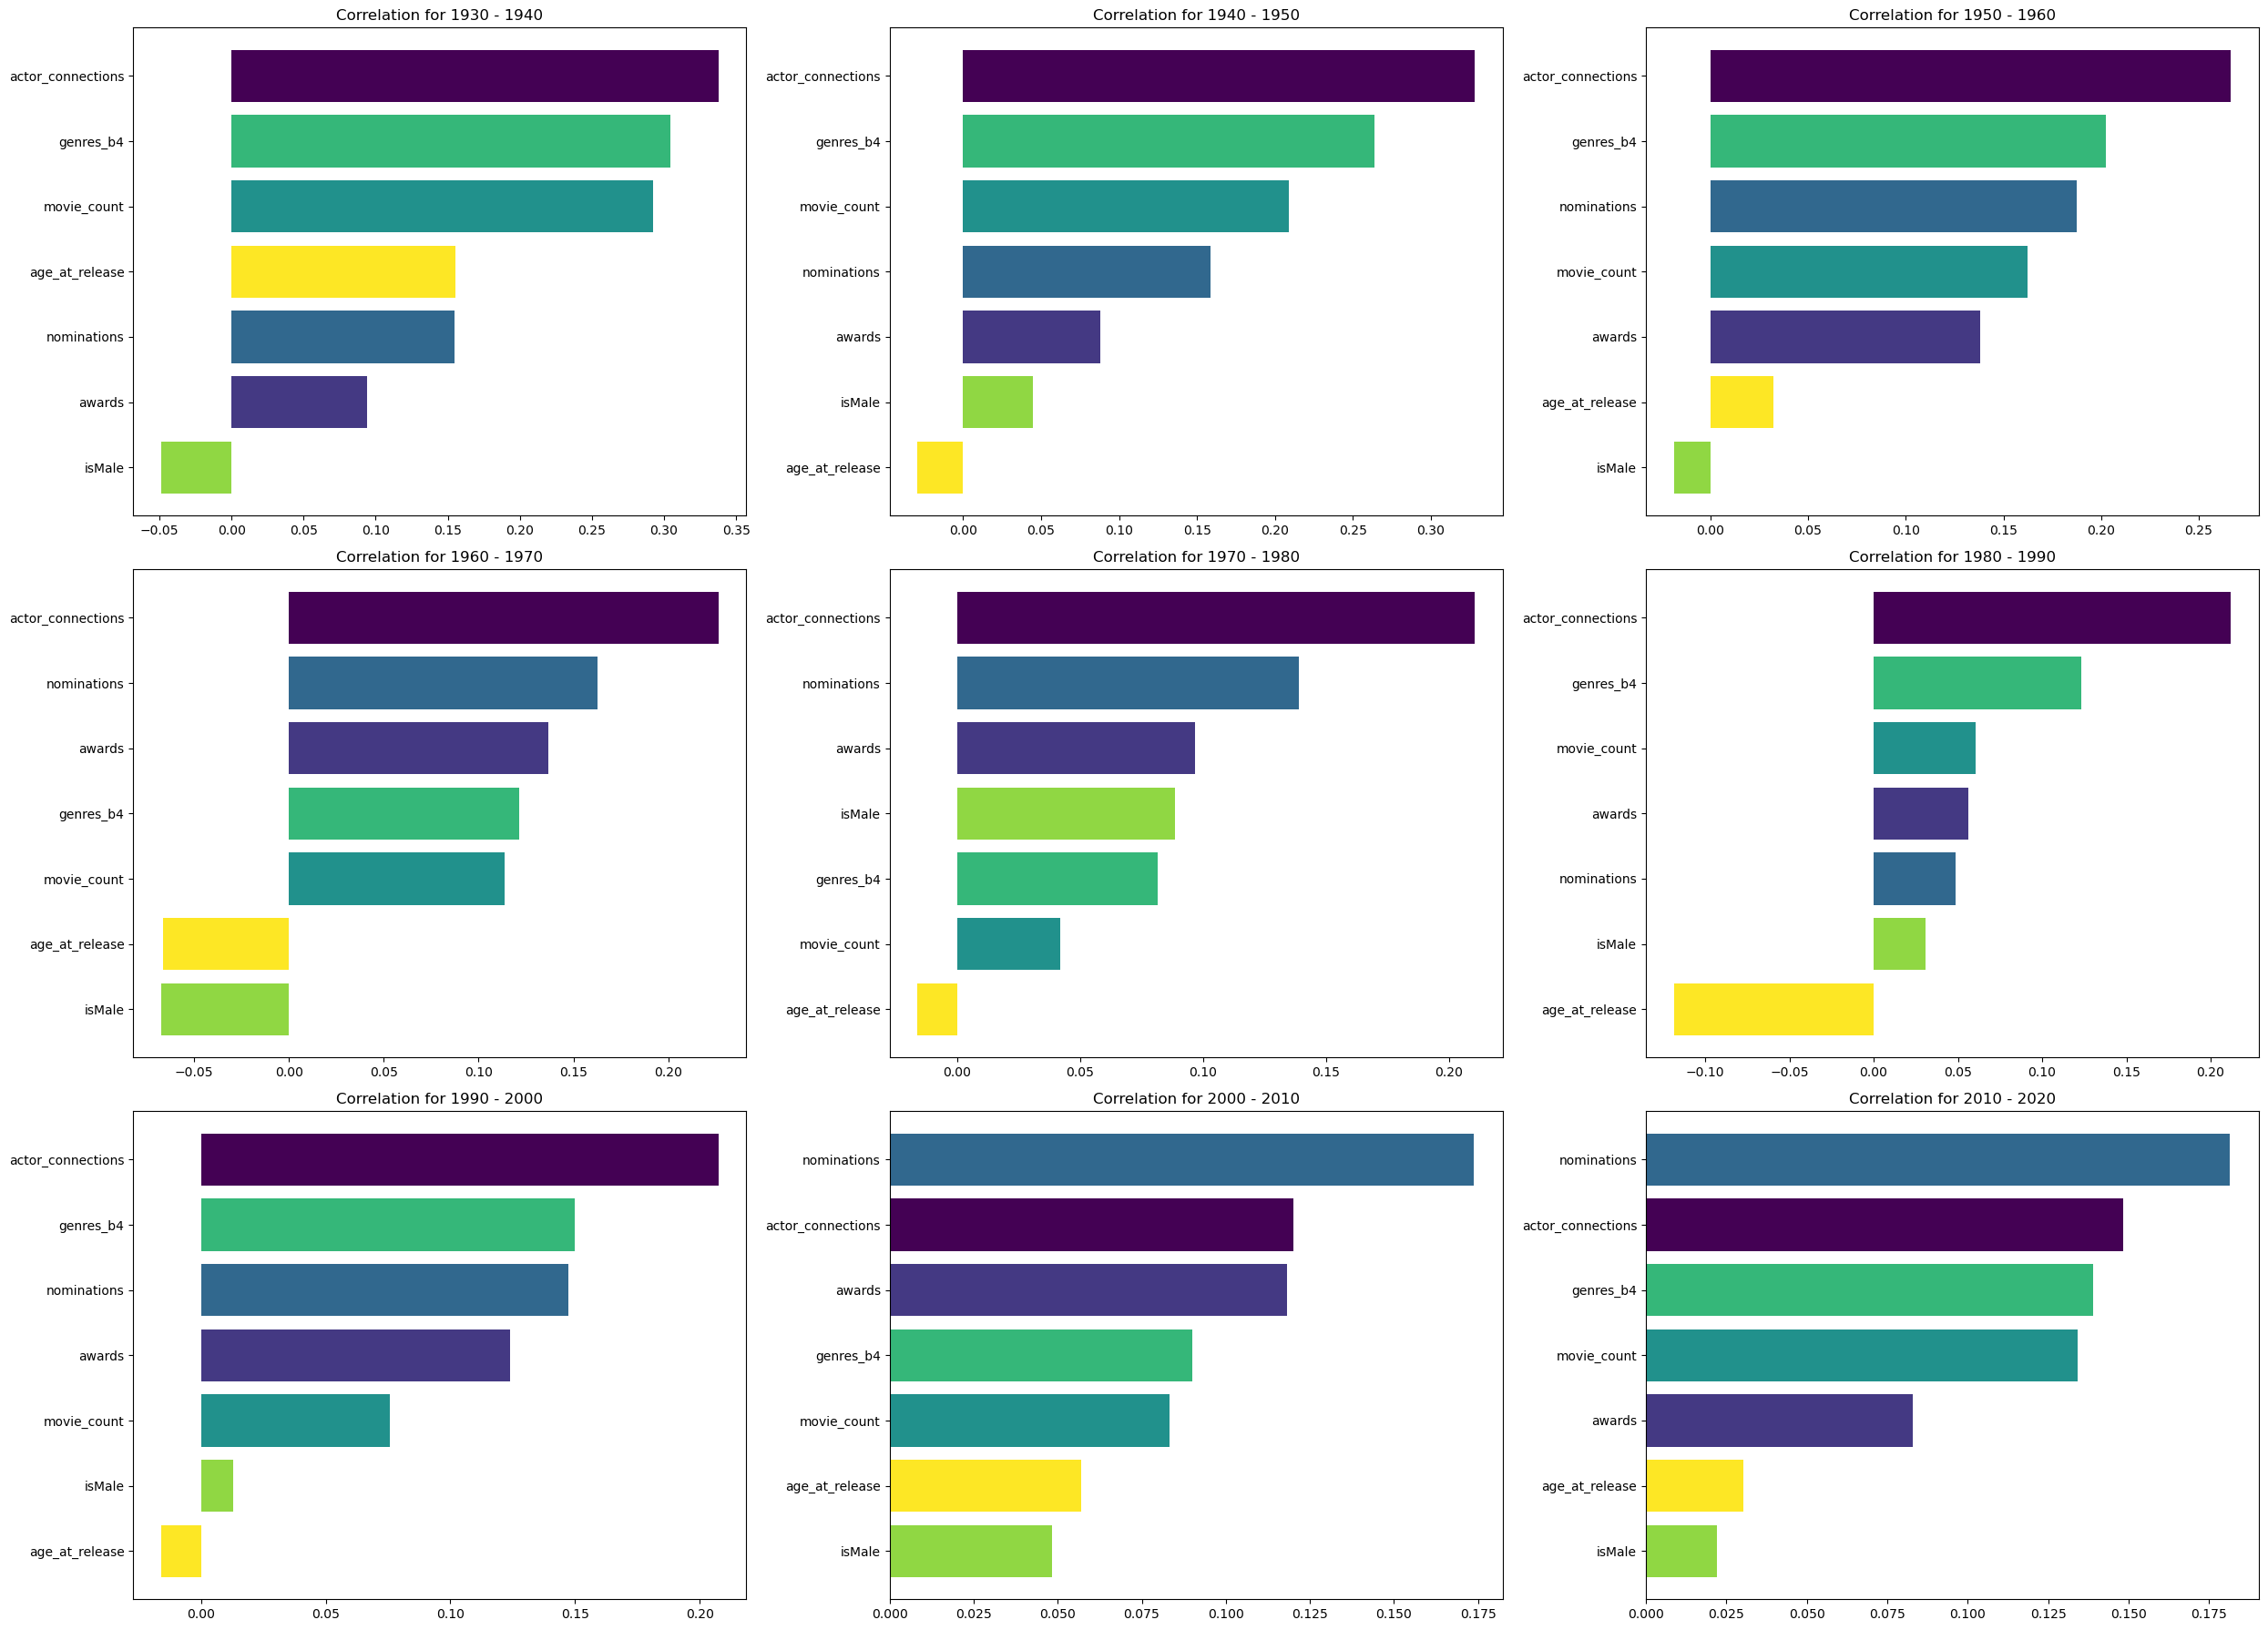

In [36]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = actors_movies['ReleaseYearRange'].unique()

# Define a colormap
cmap = plt.cm.viridis

# List of features
features = [ 'actor_connections','awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release']

# Map each feature to a numerical value
feature_values = np.linspace(0, 1, len(features))
feature_colors = {feature: cmap(value) for feature, value in zip(features, feature_values)}

for i, year_range in enumerate(Years):
    Year = actors_movies[actors_movies['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    correlation_matrix = Year[features + ['averageRating']].corr()
    correlation_with_X = correlation_matrix['averageRating'].drop('averageRating')
    correlation_with_X_sorted = correlation_with_X.sort_values()

    # Get colors for each feature
    colors = [feature_colors[feature] for feature in correlation_with_X_sorted.index]

    # Create a horizontal bar plot with specified colors
    axs[i].barh(correlation_with_X_sorted.index, correlation_with_X_sorted, color=colors)
    axs[i].set_title(f'Correlation for {year_range}')

plt.tight_layout()
plt.show()

# Analysis with Matching

In [15]:
# - Linear model (peut etre logistic regression) (Theo)
#     - voir si awards a vraiment une influence ou pas, check p value
# - Matching (Theo)
#     - avec awards, check if awards really has an influence on ratings
# - Linear model (peut etre logistic regression) (Theo)
#     - voir si awards a vraiment une influence ou pas, check pvalue, et la difference ave 1ere logreg

# PCA

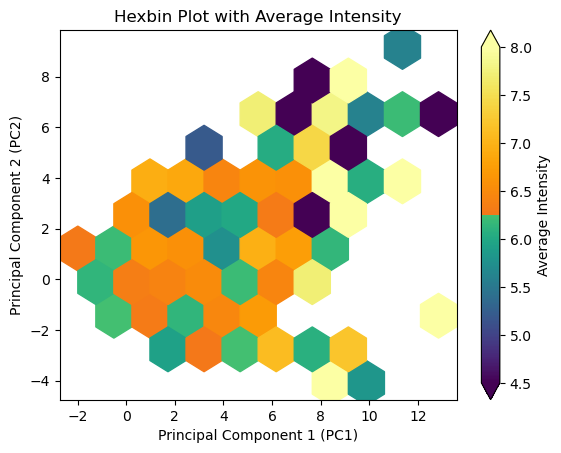

In [40]:
Years = actors_movies['ReleaseYearRange'].unique()
#Year40 = actors_movies[actors_movies['ReleaseYearRange'] == '1940 - 1950']
Year40 = actors_movies

 # Reset the index of Year to ensure alignment
Year40.reset_index(drop=True, inplace=True)

scaler = StandardScaler()
df_standardized = scaler.fit_transform(Year40[['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release', 'actor_connections']].dropna())

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Rating'] = actors_movies['averageRating']

# Set custom vmin and vmax values
vmin = 4.5  # minimum value for the color scale
vmax = 8    # maximum value for the color scale

# Create a custom colormap
colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)

# Create a hexbin plot with the custom colormap
hexbin = plt.hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=10, cmap=custom_cmap, reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('Hexbin Plot with Average Intensity')
plt.colorbar(hexbin, label='Average Intensity', extend='both')  # Add extend='both' to show color limits beyond the data range
plt.show()

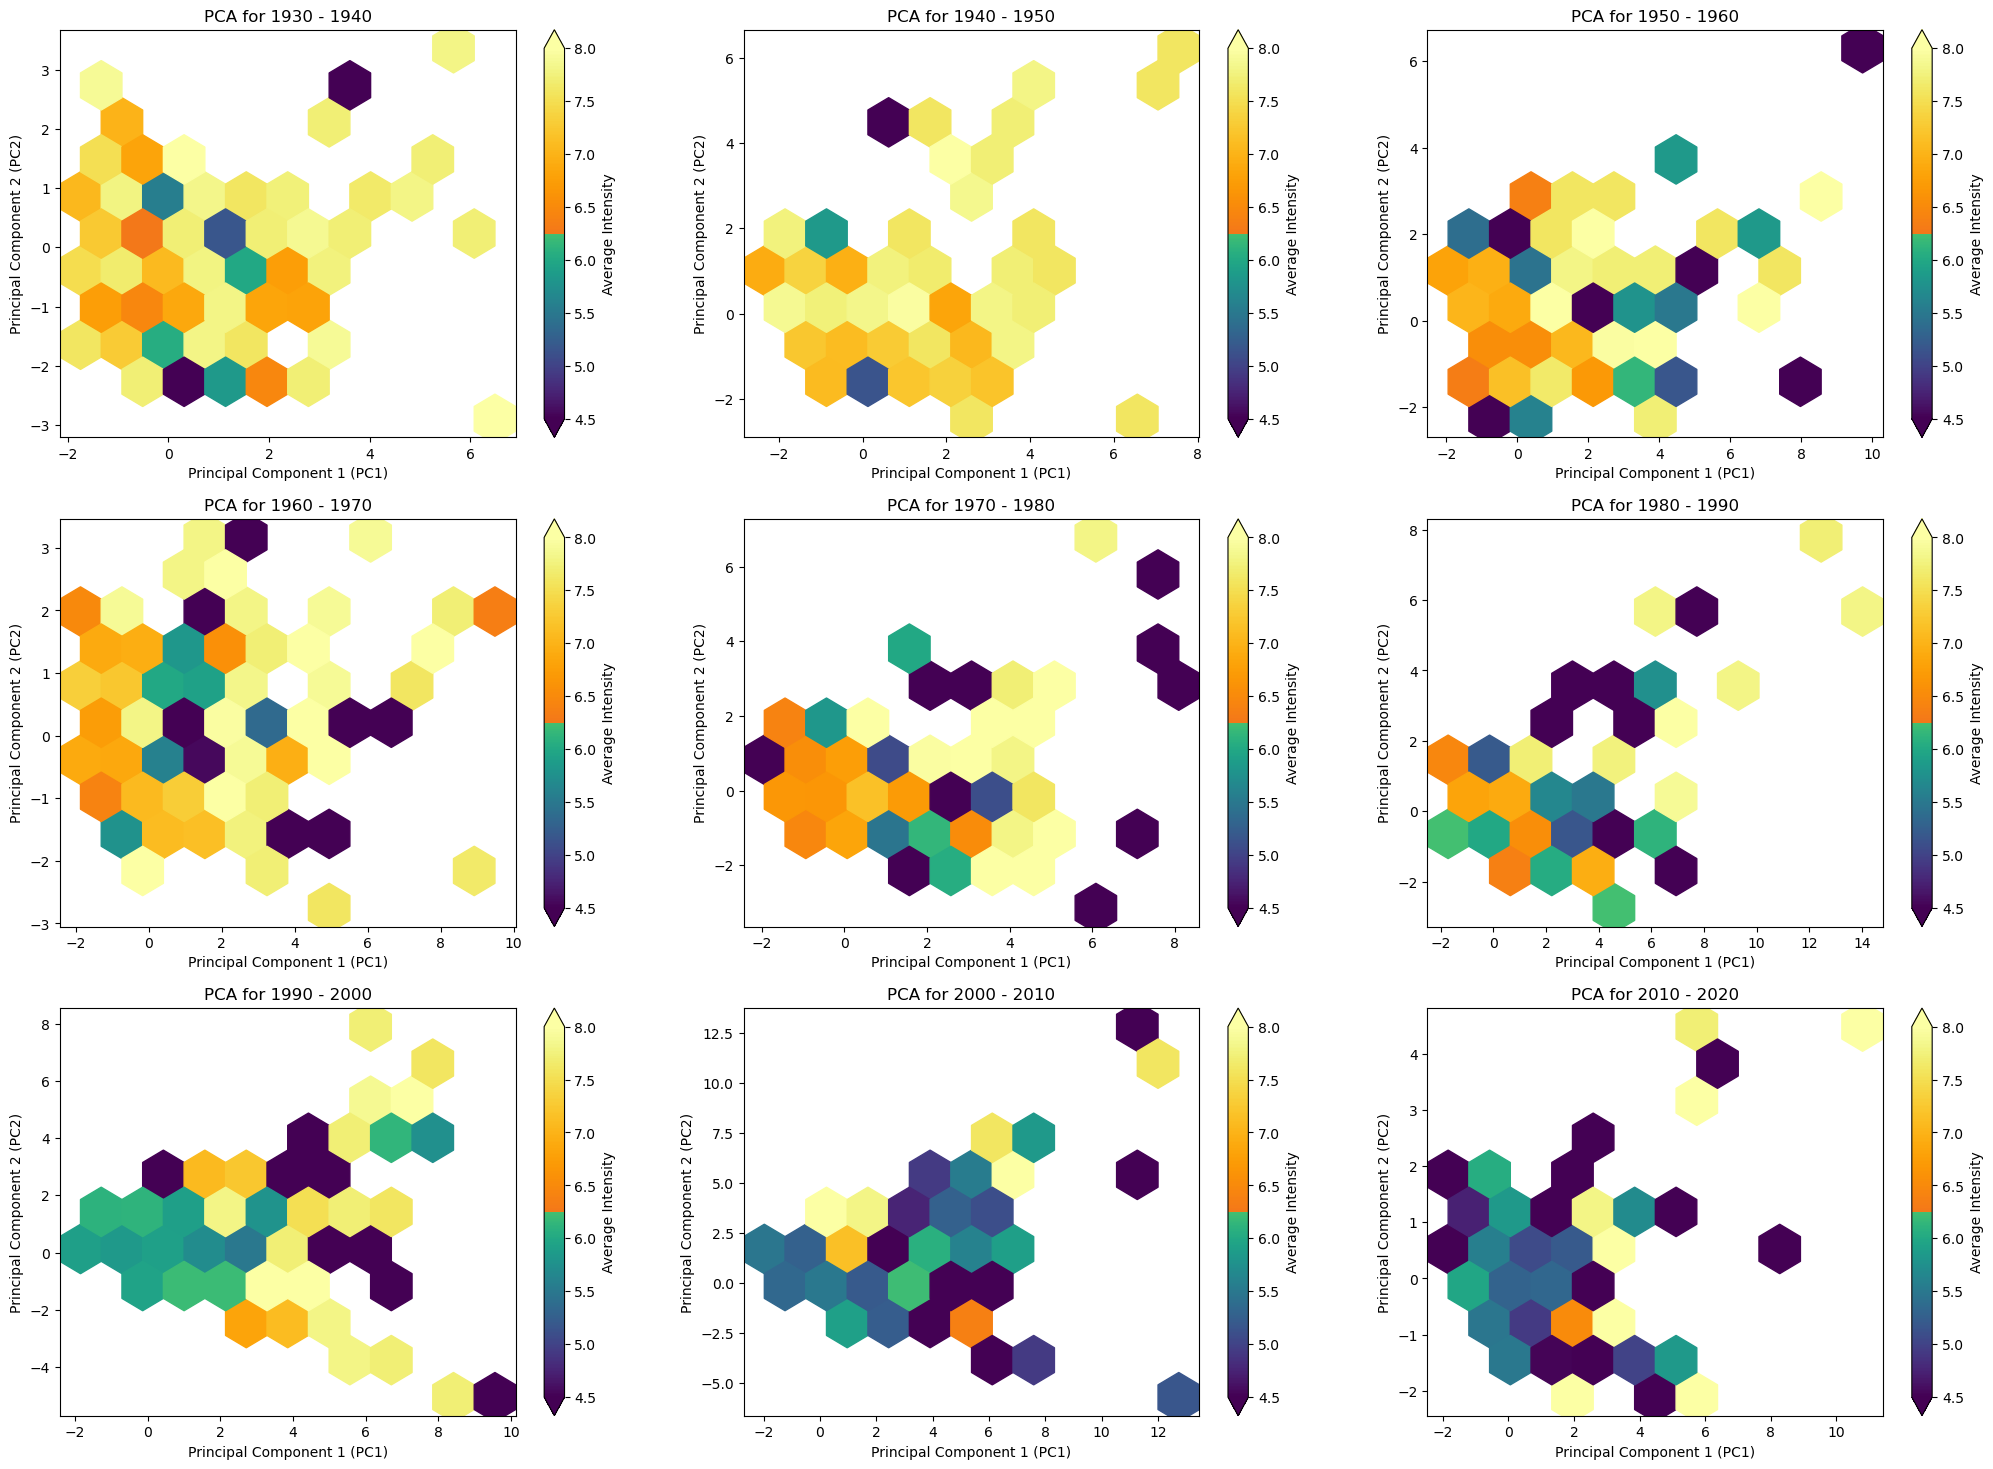

In [38]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = actors_movies['ReleaseYearRange'].unique()

for i, year_range in enumerate(Years):
    Year = actors_movies[actors_movies['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    scaler = StandardScaler()
    # Apply dropna() before scaling to ensure matching indices
    non_null_data = Year[['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release', 'actor_connections']].dropna()
    #non_null_data = Year[['awards', 'nominations', 'movie_count', 'genres_b4', 'age_at_release']].dropna()
    df_standardized = scaler.fit_transform(non_null_data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_standardized)

    # Create a DataFrame with the PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    # Use non_null_data.index to ensure correct alignment of ratings
    df_pca['Rating'] = Year.loc[non_null_data.index, 'averageRating']
    
    # Set custom vmin and vmax values
    vmin = 4.5  # minimum value for the color scale
    vmax = 8    # maximum value for the color scale
    
    # Create a custom colormap
    colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
    colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
    colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
    custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)
    
    # Create a hexbin plot with the custom colormap
    hexbin = axs[i].hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=10, cmap=custom_cmap, reduce_C_function=np.mean, vmin=vmin, vmax=vmax)


    axs[i].set_xlabel('Principal Component 1 (PC1)')
    axs[i].set_ylabel('Principal Component 2 (PC2)')
    axs[i].set_title(f'PCA for {year_range}')
    plt.colorbar(hexbin, label='Average Intensity', extend='both')

    
plt.show()

# Conclusion and future work

In [23]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances
from sklearn.metrics import accuracy_score

In [24]:

actors_movies_agg =actors_movies[['awards','nominations', 'genres_b4','Movie release date', 'averageRating', 'actor_connections']].reset_index()
actors_movies_agg = actors_movies_agg.groupby('IMDb_ID').agg({'awards': 'sum', 'nominations': 'sum', 'genres_b4': 'sum','Movie release date':'mean', 'averageRating':'mean', 'actor_connections':'mean' }).reset_index()

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have already imported necessary libraries and defined X, y, and threshold

y = actors_movies_agg['averageRating'].to_numpy()
X = actors_movies_agg[['awards', 'nominations', 'genres_b4', 'Movie release date', 'actor_connections']].to_numpy()
threshold = 6
y = y > threshold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create an instance of the DecisionTreeClassifier
classifier = DecisionTreeClassifier()

# Fit the classifier with training data
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_predict = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)


Accuracy: 0.633954857703631
